In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *
import itertools
from nilearn import image, plotting, datasets
import nibabel as nib
import pdb
import os

In [60]:
study = "spaceloc"
subj_list = list(range(1001, 1013))
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
fig_dir = f'/home/vayzenbe/GitHub_Repos/docnet/figures'
results_dir = f'{study_dir}/derivatives/results'
rois = ['PPC_spaceloc', 'APC_spaceloc', 'LO_toolloc', 'PFS_toolloc']
roi_names = ['PPC', 'APC','LO', 'PFS']

exps = ['spaceloc', 'depthloc', 'distloc', 'toolloc', 'toolloc']
exp_conds = ['space', 'depth', 'dist', 'tool', 'object']
copes = [1, 1, 1, 1, 5]
suf = '_roi'

conds = ['space', 'feature', '3D', '2D', 'tool', 'non_tool', 'distance', 'luminance']
cond_names = ['Space', 'Feature' ,'3D Shape', '2D Shape', 'Tools', 'Non-tools', 'Distance', 'Brightness']


num_vox = 200

template = datasets.load_mni152_template()

In [61]:
# create a figure with multiple axes to plot each anatomical image
def plot_glass_brain(subs, exp):
    fig, axes = plt.subplots(nrows=len(all_subs), ncols=1, figsize=(9, 25))


    # axes is a 2 dimensional numpy array
    for axn, ax in enumerate(axes.flatten()):
        display = plotting.plot_glass_brain(all_subs[axn], axes=ax, threshold = 3.1, draw_cross = False, colorbar = True)

        ax.title.set_text(f'Subject {axn + 1}')

    plt.show()
    display.savefig(f'{fig_dir}/{exp}_glassbrain.png')   
    plt.pause(0.0001)

    # save the output figure with all the anatomical images
    #fig.savefig("my_test_img.png")

In [62]:
def plot_bar(df, ylabel, roi):

    y_min = np.min(df[ylabel])
    y_max = np.max(df[ylabel]) +2

    plot = ggplot(df, aes(x='Condition', y=ylabel, color = 'Condition', fill = 'Condition')) + geom_col(color="black", position =position_dodge(width =1)) +  facet_wrap('~ROI', scales='free') + \
    geom_linerange(aes(x='Condition',  ymax = f'{ylabel} + se', ymin = f'{ylabel} - se'), color = 'black', position = position_dodge(width =1))  + \
            theme_classic() + xlab('Conditions') + ylab(ylabel) + theme(text = element_text(color ='black'), 
                                                                          axis_line=element_line(), 
                                                                          panel_border=element_blank(),
                                                                          figure_size = (15, 5),subplots_adjust={'wspace': 0.15},strip_background = element_blank())
    
    print(plot)
    plot.save(f'{fig_dir}/{roi}_{ylabel}_bar.png', width=15, height=5, dpi = 300)
    
    

In [63]:
def create_vsf(df, ylabel, roi):
    y_min = np.min(df[ylabel])
    y_max = np.max(df[ylabel])
    
    plot = ggplot(df, aes(x='Voxels', y=ylabel, color = 'Condition', fill = 'Condition')) + geom_line() + \
        theme_classic() + xlab('Voxels') + ylab(ylabel) + ylim(y_min,y_max) + theme(text = element_text(color ='black'), 
                                                                      axis_line=element_line(), 
                                                                      panel_border=element_blank(),
                                                                      figure_size = (15, 5),subplots_adjust={'wspace': 0.15},strip_background = element_blank())  + facet_wrap('~ROI', scales='free')
    
    print(plot)
    
    
    plot.save(f'{fig_dir}/{roi}_{ylabel}_vsf.png', width=15, height=5, dpi = 300)


spaceloc


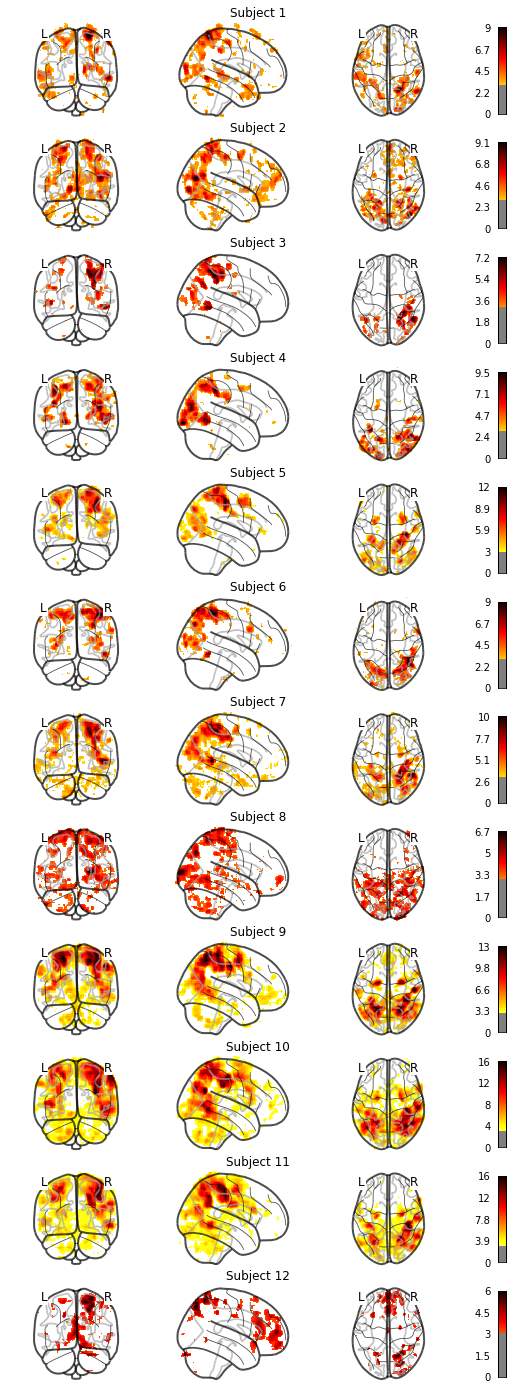

depthloc


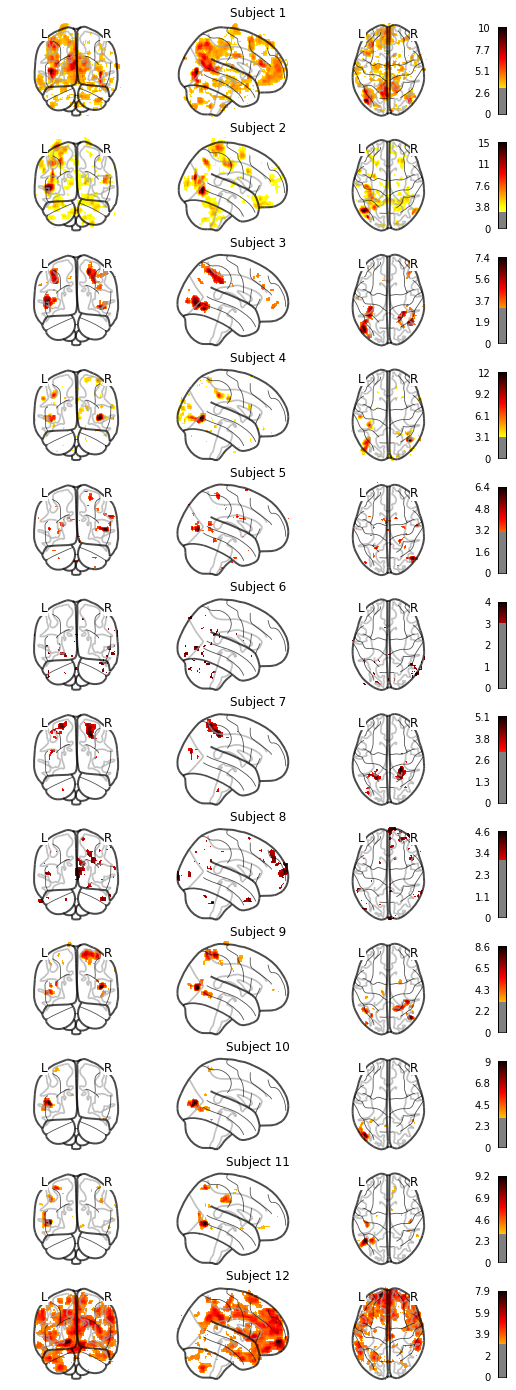

distloc


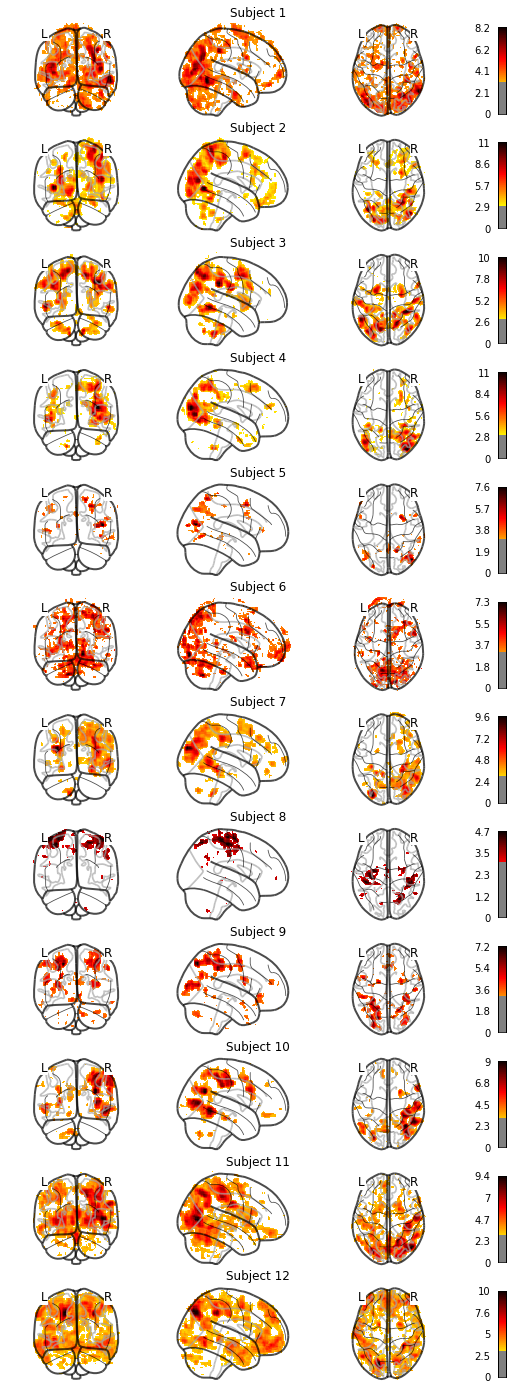

toolloc


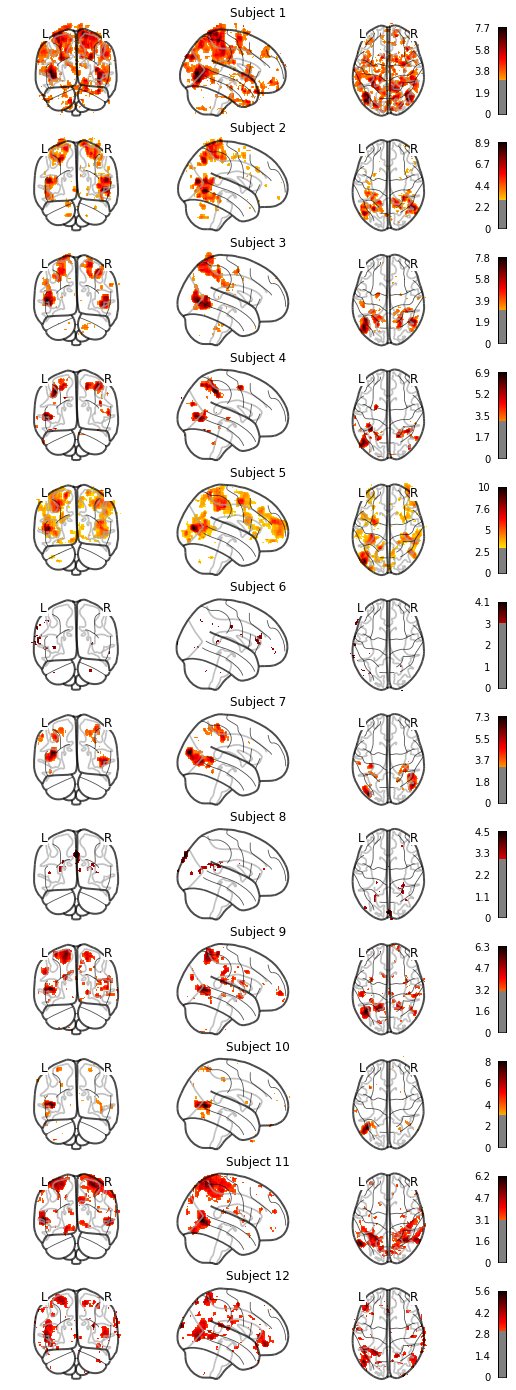

toolloc


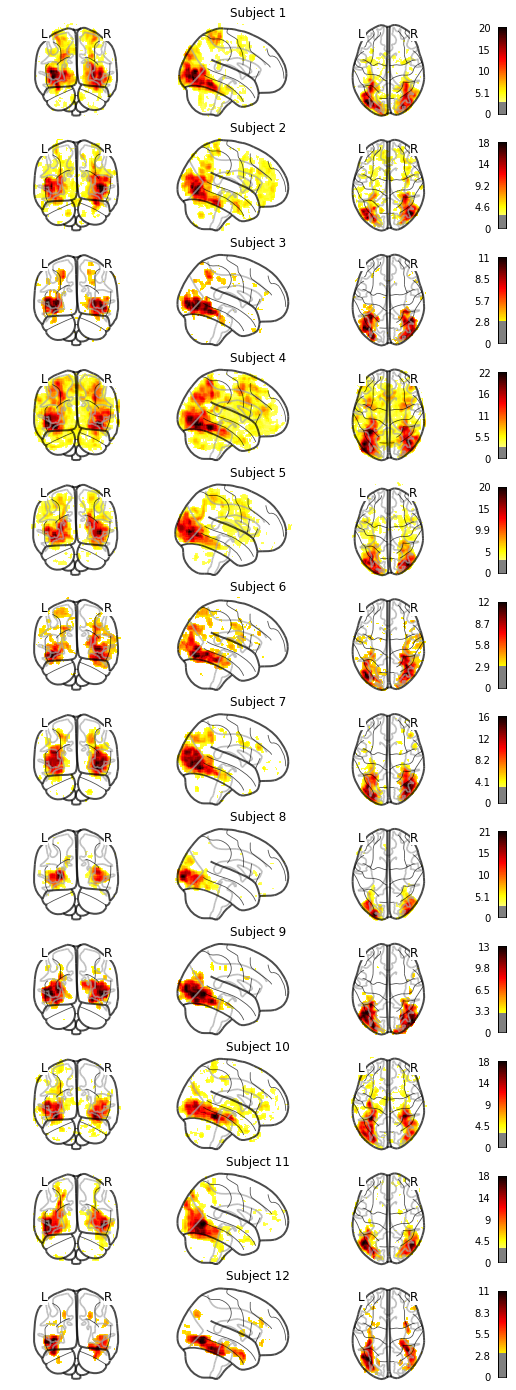

In [8]:
"""
Plot glass brain 
"""
for exn, exp in enumerate(exps):
    all_subs = []
    for ss in subj_list:
        stats_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/fsl/{exp}/HighLevel{suf}.gfeat'
        curr_sub = image.load_img(f'{stats_dir}/cope{copes[exn]}.feat/stats/zstat1.nii.gz') # load image
        
        affine = curr_sub.affine #extract original affine
        curr_sub = image.get_data(curr_sub) #convert to numpy
        
        
        curr_sub[curr_sub[:,:,:] <=0] = 0 #zero out anything negative
        #cluster_mask = image.get_data(image.load_img(f'{stats_dir}/cope{copes[exn]}.feat/stats/zstat1.nii.gz')) #load cluster corrected mask as numpy array
        
        #curr_sub = curr_sub * cluster_mask #mask with cluster-correction
        curr_sub = nib.Nifti1Image(curr_sub, affine) #convert back to volume
        curr_sub = image.resample_to_img(curr_sub, template) #resample to MNI
        all_subs.append(curr_sub)
    
    print(exp)    
    plot_glass_brain(all_subs, exp_conds[exn])
    
    
        

In [73]:
roi_conds = []
for ex in exps:
    for rr in roi_names:
        for lr in ['l', 'r']:
            roi_conds.append(f'{lr}{rr}_{ex}.nii.gz')

In [76]:
len(roi_conds)

40

In [82]:
"""
Calcualte size and quantity of each ROI for each sub
"""
#Create a list of all roi conds
roi_conds = []
for ex in exps:
    for rr in roi_names:
        for lr in ['l', 'r']:
            roi_conds.append(f'{lr}{rr}_{ex}')

roi_summary = pd.DataFrame(columns = ['subj'] + roi_conds)
for ss in subj_list:
    roi_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/rois'
    subj_data = [ss]
    for rr in roi_conds:
        print(f'{roi_dir}/{rr}.nii.gz')
        if os.path.exists(f'{roi_dir}/{rr}.nii.gz'):
            roi_nifti = image.get_data(image.load_img(f'{roi_dir}/{rr}.nii.gz'))
            roi_size = np.sum(roi_nifti == 1)

            subj_data.append(roi_size)


        else:
            subj_data.append(0)

    
    subj_data = pd.Series(subj_data, index = roi_summary.columns)
    
    roi_summary = roi_summary.append(subj_data, ignore_index = True)

/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/lPPC_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/rPPC_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/lAPC_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/rAPC_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/lLO_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/rLO_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/lPFS_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/rPFS_spaceloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/lPPC_depthloc.nii.gz
/lab_data/behrmannlab/vlad/spaceloc/sub-spaceloc1001/ses-01/derivatives/rois/rPPC_depthloc.nii.gz
/lab_data/behrmannlab/

In [97]:
roi_summary

subj lPPC_spaceloc rPPC_spaceloc lAPC_spaceloc rAPC_spaceloc lLO_spaceloc  \
0   1001           314           425           637          1050            0   
1   1002           512           842           936           831            0   
2   1003             0           605             0          1444            0   
3   1004           897          1327           931          1373          544   
4   1005           540           838           868          1746            0   
5   1006           992          1125          1302          1969            0   
6   1007           661          1742          1318          2464          251   
7   1008            90           739           741          1067            0   
8   1009          2153          2307          3146          3655            0   
9   1010          2321          2756          3264          5004            0   
10  1011          1925          2605          2788          4889            0   
11  1012             0           463             0           932            0   

   rLO_spaceloc lPFS_spaceloc rPFS_spaceloc lPPC_depthloc  ... lPFS_toolloc  \
0             0             0             0           694  ...         1133   
1             0             0             0           430  ...          548   
2             0             0             0             0  ...          611   
3           674           676           104             0  ...         1672   
4             0             0             0             0  ...          950   
5             6             2             0             0  ...          817   
6             0           231             0             0  ...         1128   
7             0             0             0             0  ...          230   
8             0             0             0             0  ...         1110   
9             0             0             0             0  ...         1449   
10            0             0             0             0  ...          882   
11            0             0             0             0  ...          964   

   rPFS_toolloc lPPC_toolloc rPPC_toolloc lAPC_toolloc rAPC_toolloc  \
0           727          808          704         1226         2091   
1           759          248           86          731          929   
2           469          297          147          815          812   
3          1102          115          135          453          450   
4           840          202            8         1199          904   
5           899            0            0            0            0   
6           773          219            2          126          231   
7           118            0            0            0            0   
8           446          108           24          714          271   
9          1071            0            0            0            0   
10          735          187          249         1003         1188   
11          688           39            0          406            0   

   lLO_toolloc rLO_toolloc lPFS_toolloc rPFS_toolloc  
0         3602        2878         1133          727  
1         3048        3326          548          759  
2         2361        2181          611          469  
3         4763        3996         1672         1102  
4         3321        2827          950          840  
5         1741        1783          817          899  
6         3277        3310         1128          773  
7         2011        1861          230          118  
8         3591        2681         1110          446  
9         3591        2314         1449         1071  
10        3177        2774          882          735  
11        1636        1186          964          688  

[12 rows x 41 columns]

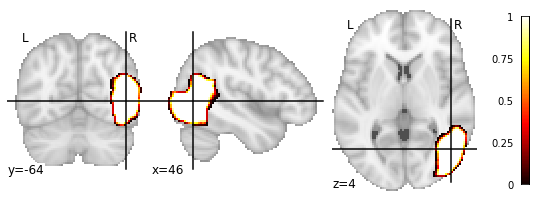

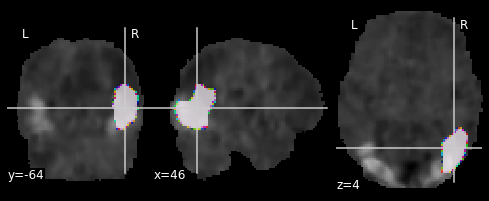

In [58]:
ss = 1001
exp= "toolloc"
rr= 'rLO_toolloc'
stats_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/fsl/{exp}/HighLevel{suf}.gfeat'
curr_sub = image.load_img(f'{stats_dir}/cope5.feat/stats/zstat1.nii.gz') # load image
roi_dir = f'{study_dir}/sub-{study}{ss}/ses-01/derivatives/rois'

roi = f'{roi_dir}/parcels/rLO.nii.gz'
display = plotting.plot_stat_map(roi)
plotting.plot_roi(roi, bg_img = curr_sub) 

spaceloc depthloc


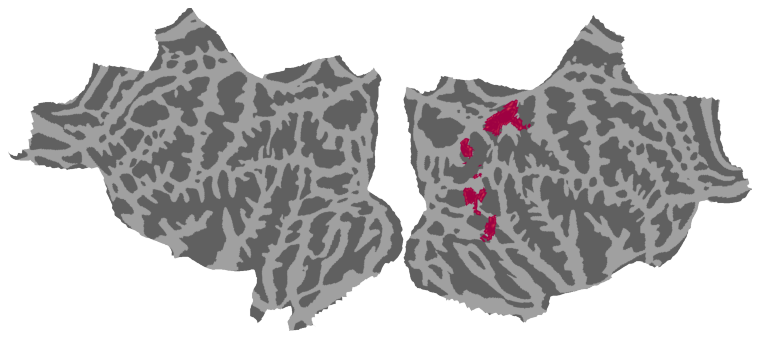

spaceloc distloc


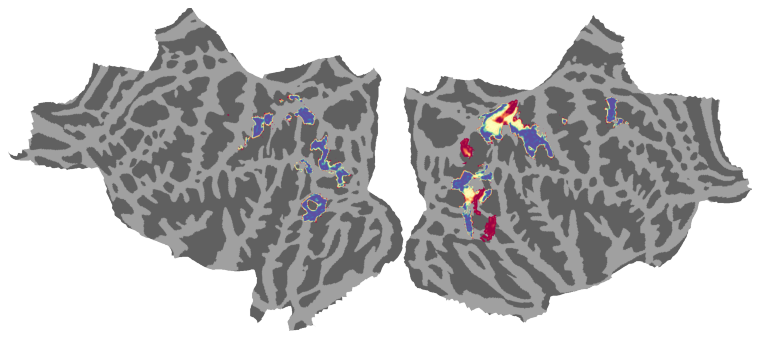

spaceloc toolloc


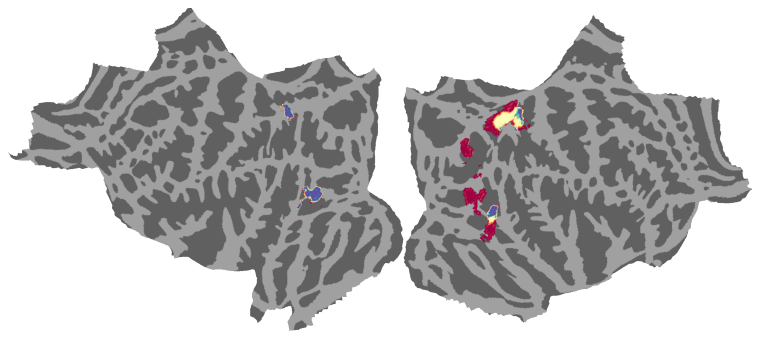

In [81]:
"""Load pre computed flat maps for display"""

exp = ['depthloc', 'distloc', 'toolloc']
for ex in exp:
    print('spaceloc', ex)
    plt.figure(figsize=(12, 6), dpi=80)
    im = plt.imread(f'spaceloc_{ex}_conjunction.png')
    plt.axis('off')
    plt.imshow(im)
    plt.pause(0.0001)

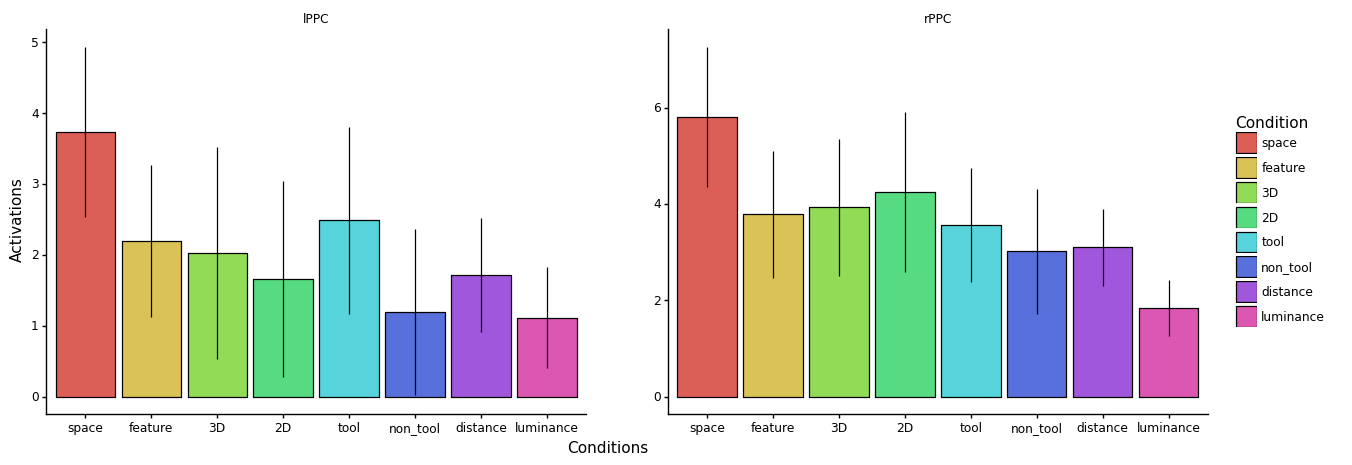

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PPC_spaceloc_Activations_bar.png


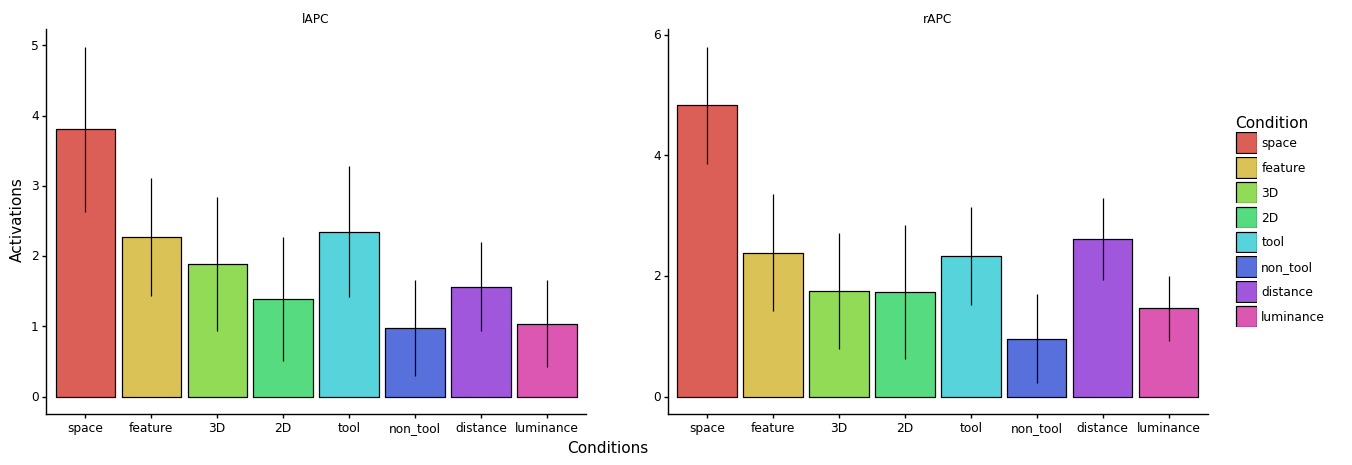

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/APC_spaceloc_Activations_bar.png


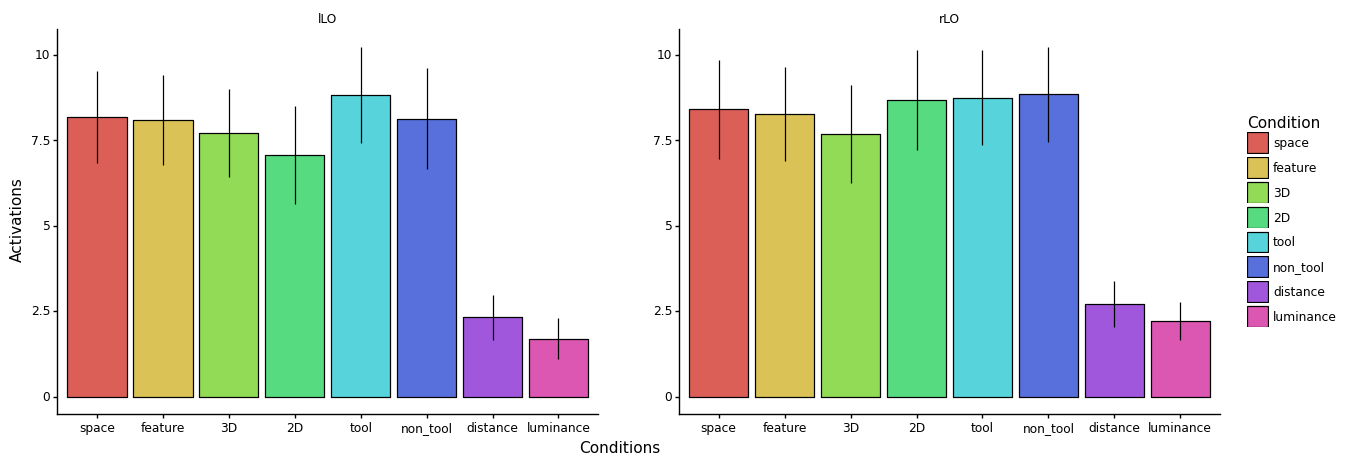

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/LO_toolloc_Activations_bar.png


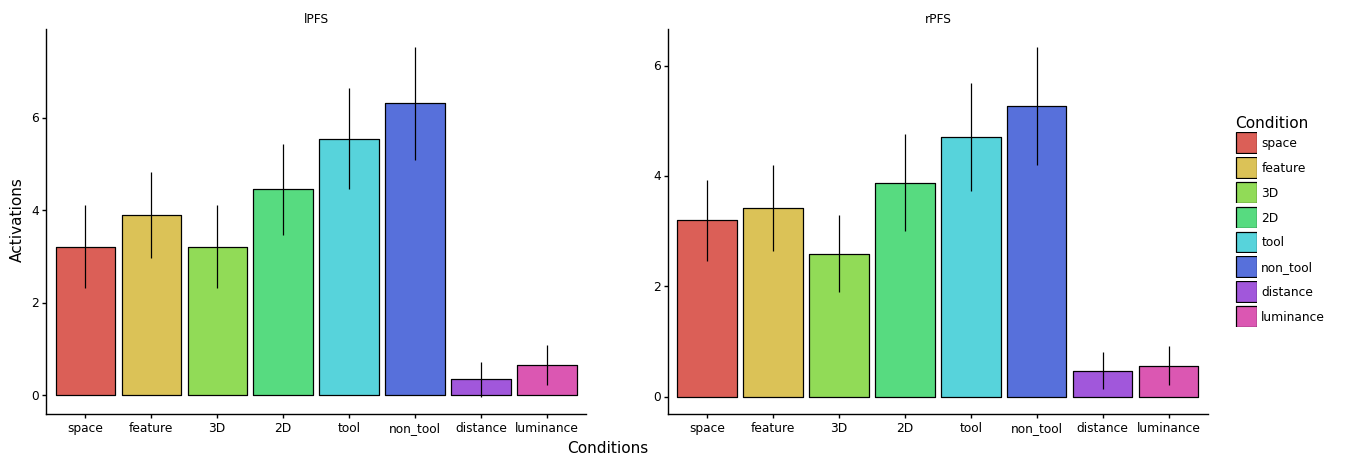

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PFS_toolloc_Activations_bar.png


In [89]:
"""
Average Activation for each ROI
"""
data_type = "activations"

for rn, rr in enumerate(rois):

    summary_df =pd.DataFrame(columns = ['Condition', data_type.capitalize(), 'se'])
    temp_summary =pd.DataFrame(columns = ['Condition', data_type.capitalize(), 'se'])

    # load ROI 1
    df = pd.read_csv(f'{results_dir}/l{rr}_mean_{data_type}.csv')
    df = df.iloc[0:num_vox,:].mean()

    summary_df['Condition'] = df.index
    summary_df[data_type.capitalize()] = df.to_list()

    df_se = pd.read_csv(f'{results_dir}/l{rr}_se_{data_type}.csv')
    df_se = df_se.iloc[0:num_vox,:].mean()

    summary_df[f'se']  = df_se.to_list()
    summary_df['ROI'] = f'l{roi_names[rn]}'

    #load ROI 2
    df = pd.read_csv(f'{results_dir}/r{rr}_mean_{data_type}.csv')
    df = df.iloc[0:num_vox,:].mean()

    temp_summary['Condition'] = df.index
    temp_summary[data_type.capitalize()] = df.to_list()

    df_se = pd.read_csv(f'{results_dir}/r{rr}_se_{data_type}.csv')
    df_se = df_se.iloc[0:num_vox,:].mean()

    temp_summary['se']  = df_se.to_list()
    temp_summary['ROI'] = f'r{roi_names[rn]}'


    #combine
    summary_df = summary_df.append(temp_summary)

    summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories = conds, ordered = False)
    
    plot_bar(summary_df, data_type.capitalize(), rr)


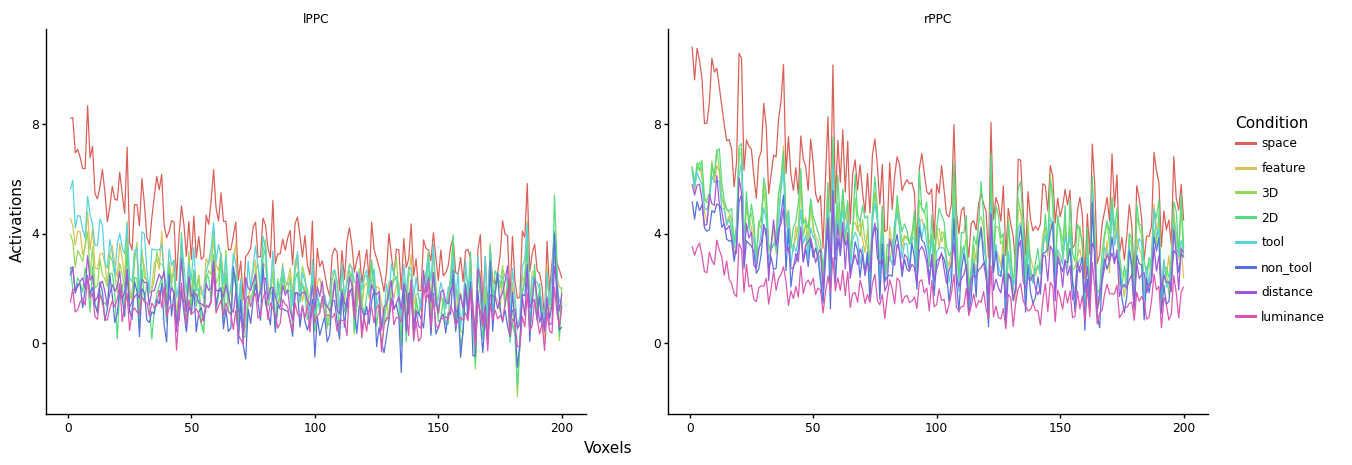

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PPC_spaceloc_Activations_vsf.png


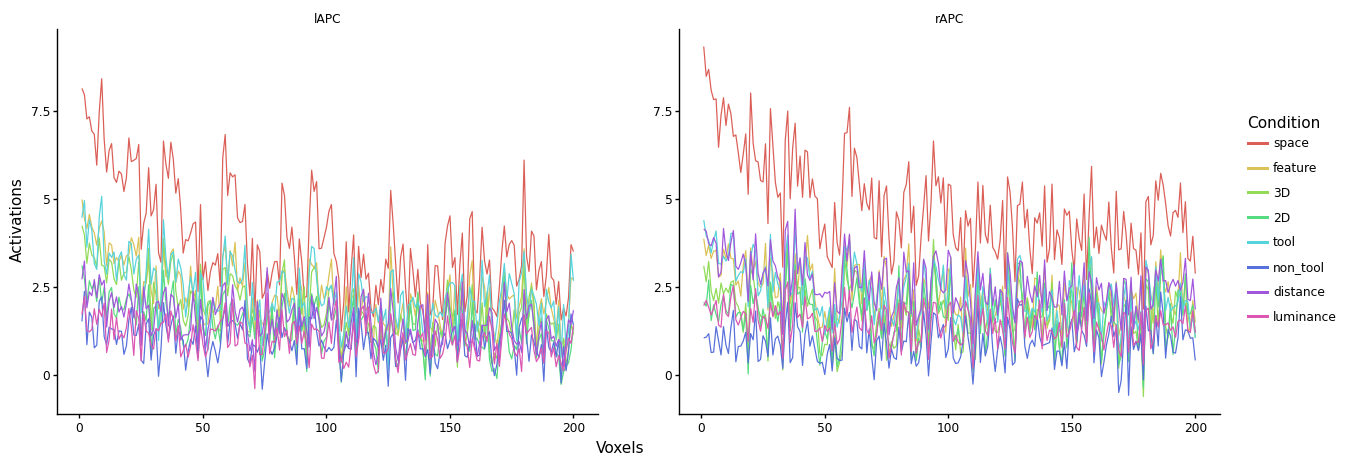

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/APC_spaceloc_Activations_vsf.png


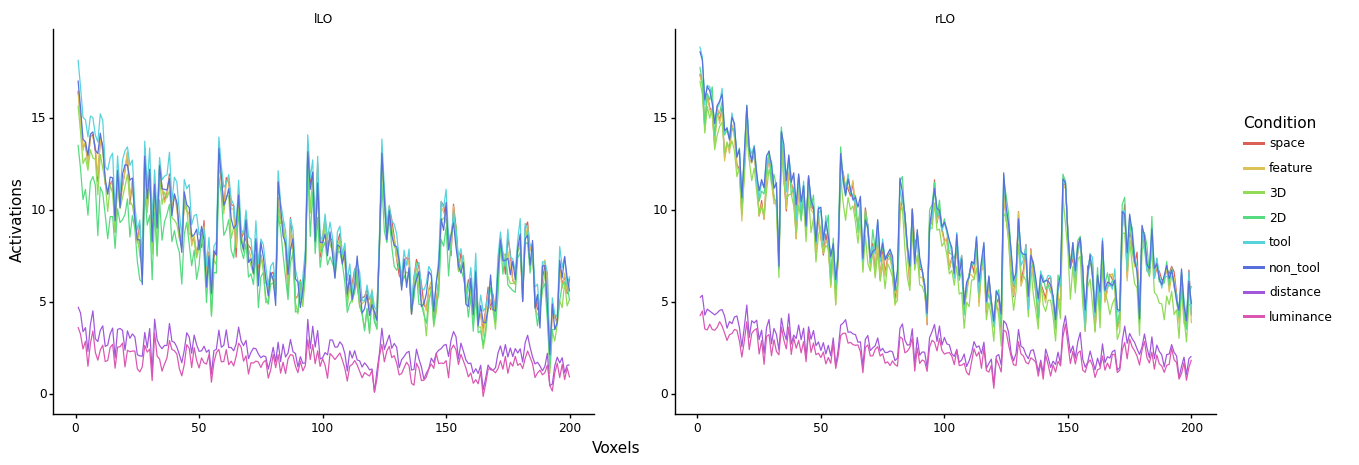

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/LO_toolloc_Activations_vsf.png


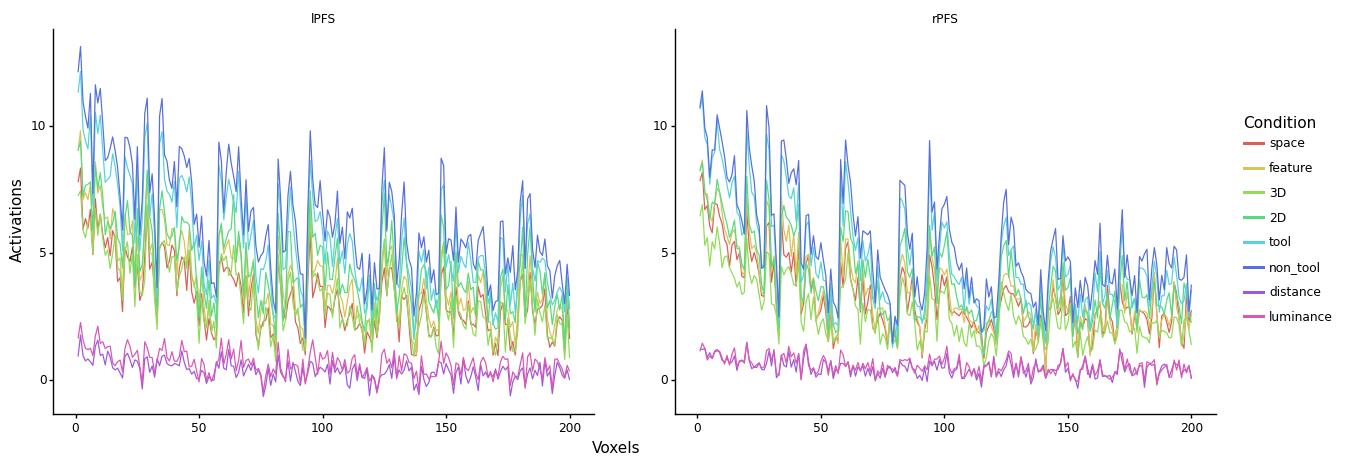

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PFS_toolloc_Activations_vsf.png


In [90]:
"""
Voxel-wise activation for each ROI

"""

data_type = "activations"

for rn, rr in enumerate(rois):
    #load left roi
    df = pd.read_csv(f'{results_dir}/l{rr}_mean_{data_type}.csv')
    df['Voxels'] = df.index +1
    df = df.iloc[0:num_vox,:]
    df_melt = pd.melt(df, id_vars='Voxels', var_name = 'Condition', value_name = data_type.capitalize())
    df_melt['ROI'] = f'l{roi_names[rn]}'    
    #load right roi 
    df2 = pd.read_csv(f'{results_dir}/r{rr}_mean_{data_type}.csv')
    df2['Voxels'] = df2.index +1
    df2 = df2.iloc[0:num_vox,:]
    df_melt2 = pd.melt(df2, id_vars='Voxels', var_name = 'Condition', value_name = data_type.capitalize())
    df_melt2['ROI'] = f'r{roi_names[rn]}'
    
    #combine left and right rois
    df_melt = df_melt.append(df_melt2)
    
    df_melt['Condition'] = pd.Categorical(df_melt['Condition'], categories = conds, ordered = False)


    create_vsf(df_melt, data_type.capitalize(), rr)

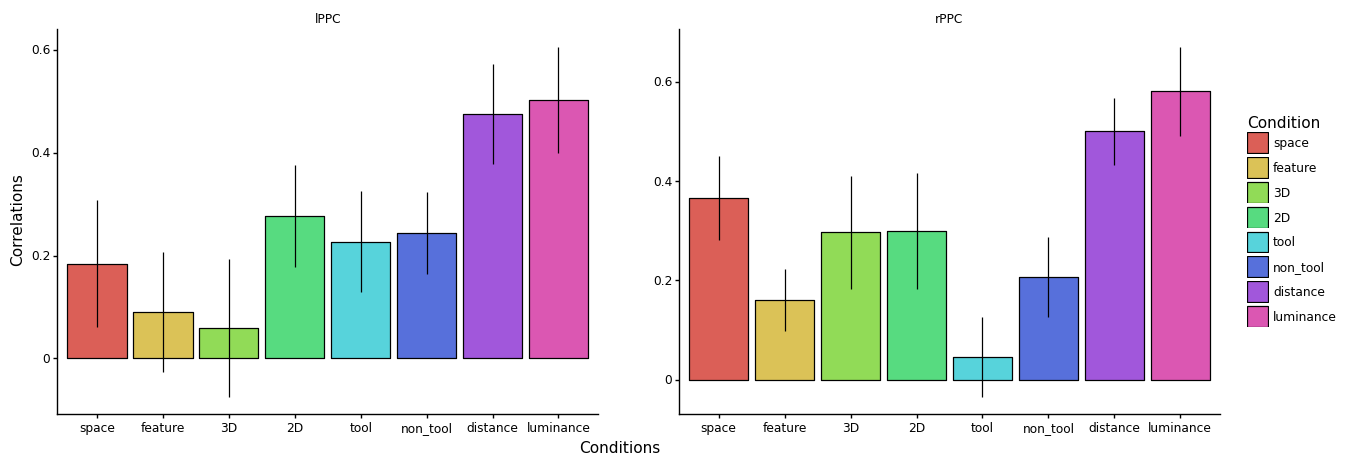

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PPC_spaceloc_Correlations_bar.png


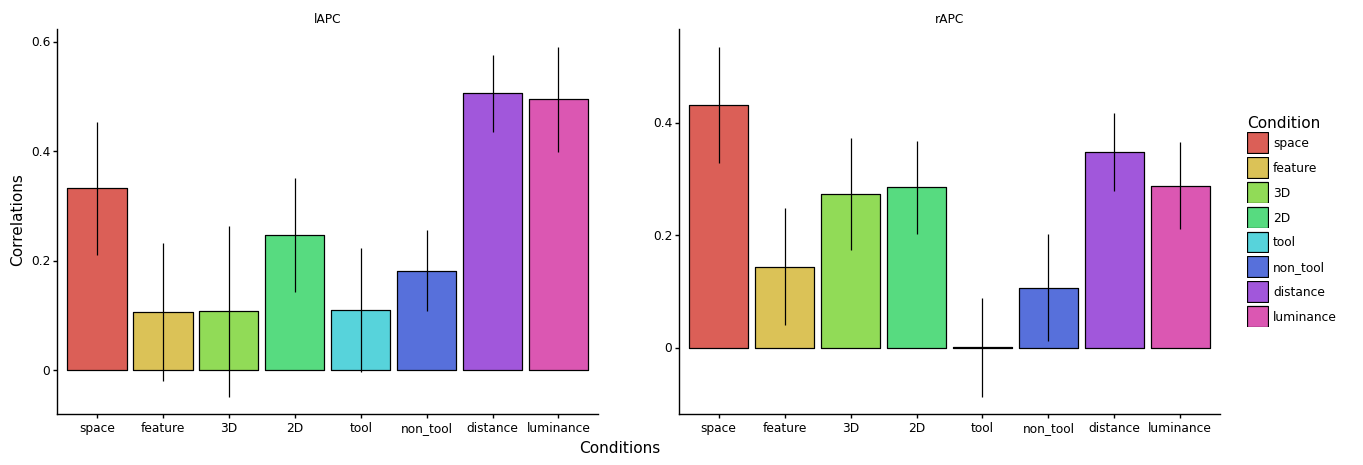

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/APC_spaceloc_Correlations_bar.png


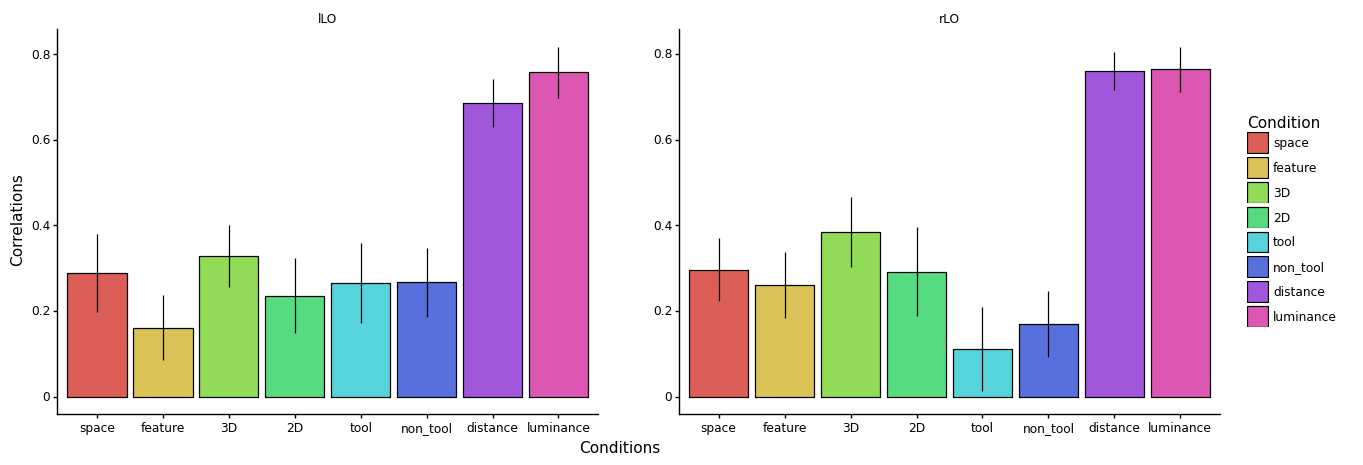

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/LO_toolloc_Correlations_bar.png


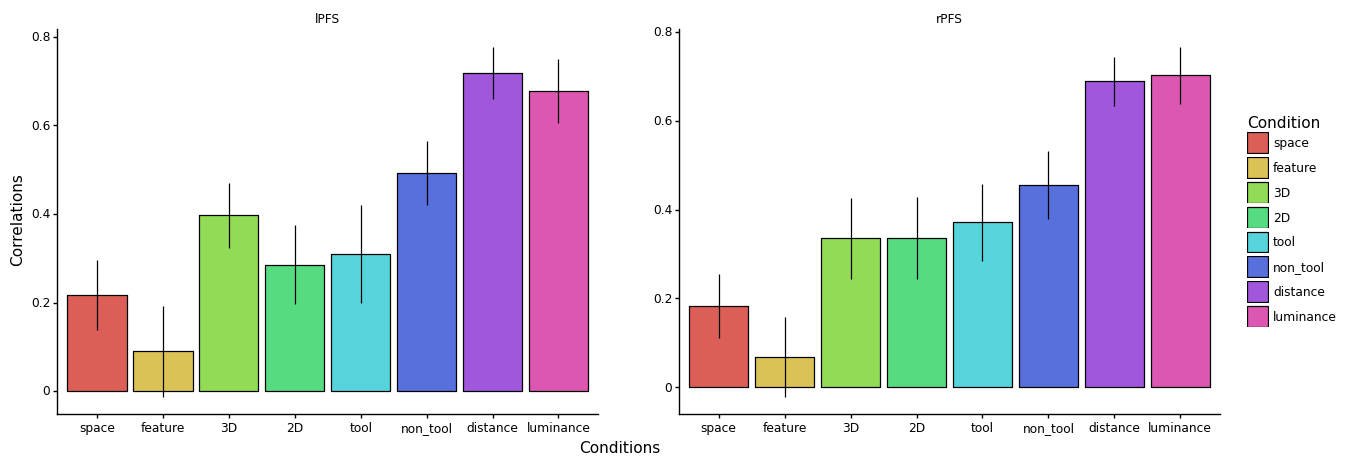

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PFS_toolloc_Correlations_bar.png


In [92]:
"""
Average MVPA for each ROI
"""
data_type = "correlations"

for rn, rr in enumerate(rois):

    summary_df =pd.DataFrame(columns = ['Condition', data_type.capitalize(), 'se'])
    temp_summary =pd.DataFrame(columns = ['Condition', data_type.capitalize(), 'se'])

    # load ROI 1
    df = pd.read_csv(f'{results_dir}/l{rr}_mean_{data_type}.csv')
    df = df.iloc[0:num_vox,:].mean()

    summary_df['Condition'] = df.index
    summary_df[data_type.capitalize()] = df.to_list()

    df_se = pd.read_csv(f'{results_dir}/l{rr}_se_{data_type}.csv')
    df_se = df_se.iloc[0:num_vox,:].mean()

    summary_df[f'se']  = df_se.to_list()
    summary_df['ROI'] = f'l{roi_names[rn]}'

    #load ROI 2
    df = pd.read_csv(f'{results_dir}/r{rr}_mean_{data_type}.csv')
    df = df.iloc[0:num_vox,:].mean()

    temp_summary['Condition'] = df.index
    temp_summary[data_type.capitalize()] = df.to_list()

    df_se = pd.read_csv(f'{results_dir}/r{rr}_se_{data_type}.csv')
    df_se = df_se.iloc[0:num_vox,:].mean()

    temp_summary['se']  = df_se.to_list()
    temp_summary['ROI'] = f'r{roi_names[rn]}'


    #combine
    summary_df = summary_df.append(temp_summary)

    summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories = conds, ordered = False)
    
    plot_bar(summary_df, data_type.capitalize(), rr)


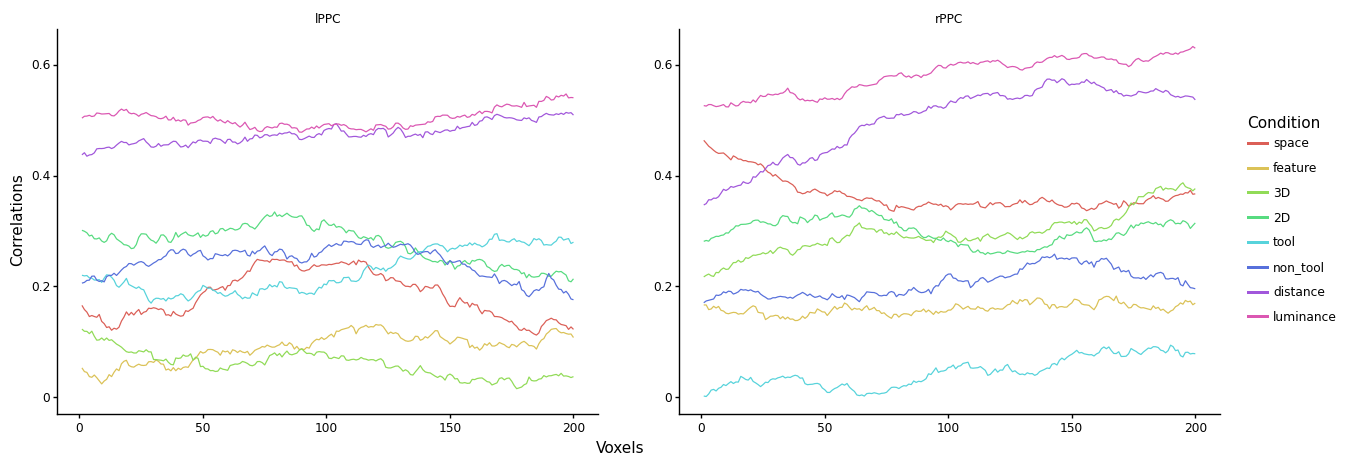

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PPC_spaceloc_Correlations_vsf.png


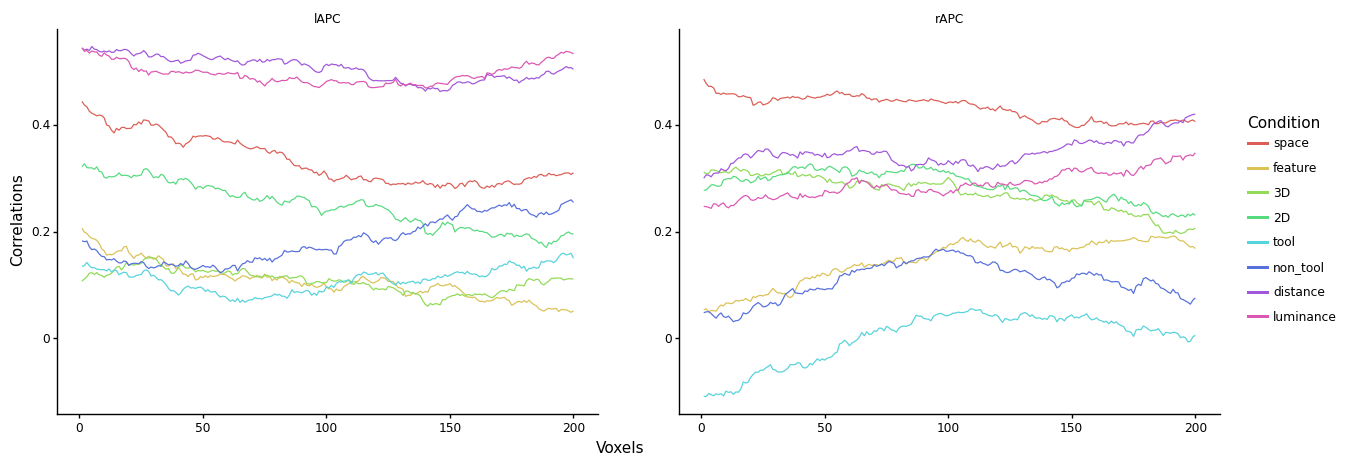

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/APC_spaceloc_Correlations_vsf.png


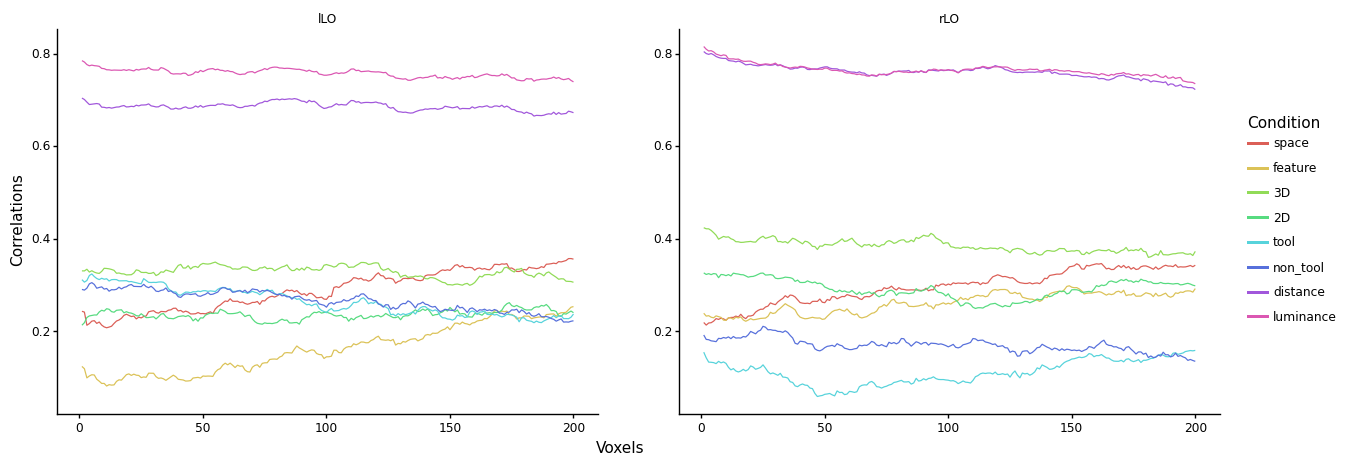

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/LO_toolloc_Correlations_vsf.png


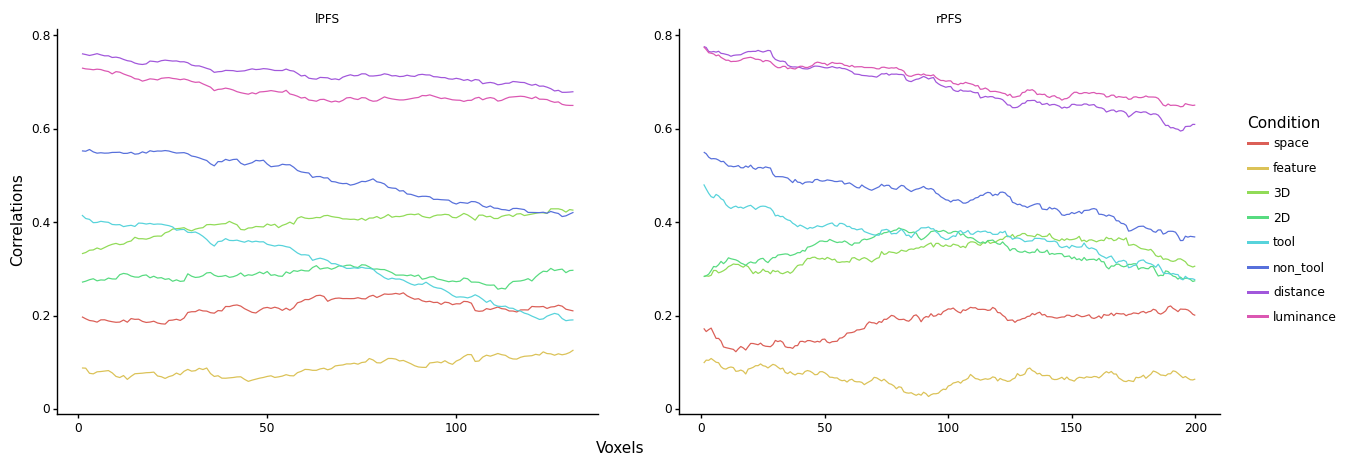

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/vayzenbe/GitHub_Repos/docnet/figures/PFS_toolloc_Correlations_vsf.png


In [94]:
"""
Voxel-wise MVPA for each ROI

"""

data_type = "correlations"

for rn, rr in enumerate(rois):
    #load left roi
    df = pd.read_csv(f'{results_dir}/l{rr}_mean_{data_type}.csv')
    df['Voxels'] = df.index +1
    df = df.iloc[0:num_vox,:]
    df_melt = pd.melt(df, id_vars='Voxels', var_name = 'Condition', value_name = data_type.capitalize())
    df_melt['ROI'] = f'l{roi_names[rn]}'    
    #load right roi 
    df2 = pd.read_csv(f'{results_dir}/r{rr}_mean_{data_type}.csv')
    df2['Voxels'] = df2.index +1
    df2 = df2.iloc[0:num_vox,:]
    df_melt2 = pd.melt(df2, id_vars='Voxels', var_name = 'Condition', value_name = data_type.capitalize())
    df_melt2['ROI'] = f'r{roi_names[rn]}'
    
    #combine left and right rois
    df_melt = df_melt.append(df_melt2)
    
    df_melt['Condition'] = pd.Categorical(df_melt['Condition'], categories = conds, ordered = False)


    create_vsf(df_melt, data_type.capitalize(),rr)